In [21]:
import re
import random
import pandas as pd
import hashlib

In [ ]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [23]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Do Androids Dream of Electric Sheep? Dick,15.028417,5.009472,7.139610,3
"Jane Eyre, Bronte",146.609159,18.326145,26.729698,8
Email Auth and Security,493.639998,61.705000,141.181374,8
Azure AD Authentication,499.863847,41.655321,110.332802,12
Logging in Python,531.964034,37.997431,78.042498,14
RAG Project,822.782699,82.278270,226.756025,10
Debugging in VS Code,975.019068,88.638097,220.912735,11
Azure Private DNS,1054.508282,55.500436,124.248740,19
C# Basics,1277.886388,41.222142,110.998859,31
Azure Functions + PP365,1509.969745,71.903321,198.100079,21


# Histogram

sum of ages: ~37582.76


<Axes: >

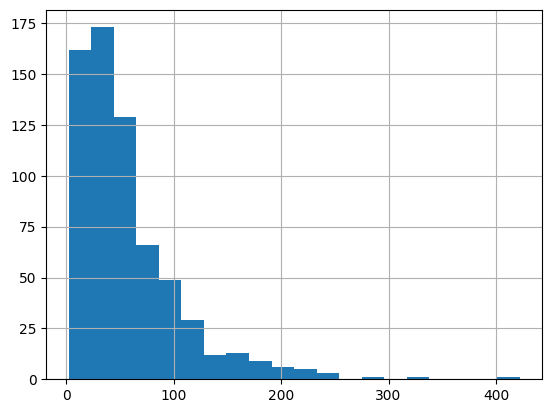

In [24]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~37582.76


<Axes: >

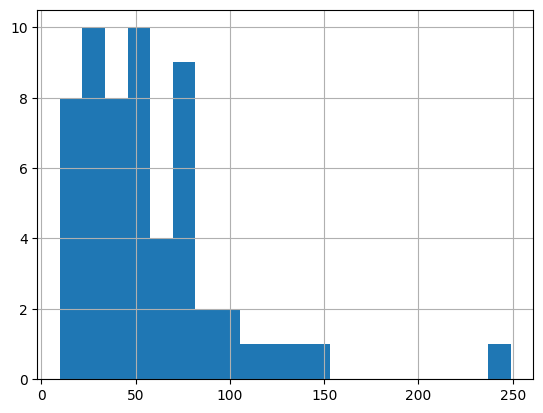

In [42]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [26]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [27]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [28]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [29]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [30]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [31]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [32]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [33]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [34]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [35]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [36]:
n=5
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 659
Total card age: 37582.76


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
445,Do Androids Dream of Electric Sheep? Dick,"Caterwauled (KAT-er-wawld): Past tense of ""cat...",e0d5418fcba056043cbe9db9b68ebc68,7.139610,5.009472,7.139610,15.028417,0.702457,3,0,0,-7.139610
224,Do Androids Dream of Electric Sheep? Dick,"Cogitated (KOJ-i-teyt-ed): Past tense of ""cogi...",43b7b6ed69e2071e68043d97b76820b2,5.647800,5.009472,7.139610,15.028417,0.702457,3,1,0,-5.647800
658,Do Androids Dream of Electric Sheep? Dick,Kipple (KIP-uhl): A term coined by author Phil...,087bf4b74ec5d79f84513edb5dad7fdc,2.241007,5.009472,7.139610,15.028417,0.702457,3,2,0,-2.241007
214,Email Auth and Security,p=quarantine\n\nA DMARC policy action.\nInstru...,ef938783fc320a6d315dde8501f4b254,141.181374,61.705000,141.181374,493.639998,0.133586,8,0,0,-141.181374
435,Email Auth and Security,Feedback Loops (FBL)\n\nMechanisms by which em...,4c90f267d5996ebd5f6f67fab81061d5,102.178515,61.705000,141.181374,493.639998,0.133586,8,1,0,-102.178515
650,Email Auth and Security,Email Authentication Alignment\n\nEnsuring tha...,14bc6ca0af379197455f1cd5febad55c,100.617261,61.705000,141.181374,493.639998,0.133586,8,2,0,-100.617261
215,Email Auth and Security,SMTP (Simple Mail Transfer Protocol)\n\nThe st...,6d00c60b39db9ac1eabdc490adf128a4,53.121620,61.705000,141.181374,493.639998,0.133586,8,3,0,-53.121620
436,Email Auth and Security,BIMI (Brand Indicators for Message Identificat...,2108ca953bb72f3c995be925bc4f8e9e,36.296206,61.705000,141.181374,493.639998,0.133586,8,4,0,-36.296206
443,"Jane Eyre, Bronte",Salubrious\n(suh-LOO-bree-uhs) Describing some...,a4e97a6bcfb2423b479db36526595e42,26.729698,18.326145,26.729698,146.609159,0.775480,8,0,0,-26.729698
221,"Jane Eyre, Bronte",Basin and Ewer\n(BAY-sin and YOO-er) A bowl (b...,a985a5826fd5d734c4090f3f9d253305,26.547886,18.326145,26.729698,146.609159,0.775480,8,1,0,-26.547886



## Random

In [37]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [38]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
16,Asynchronous Python,Awaitable\nAny object in Python that can be us...,56b47f1b55955533a2140918db6d5be0,421.918657,75.231269,421.918657,3460.638382,0.683297,46,0,0,-421.918657
80,PowerShell Modules,Module Scope Management\n\nDefinition: Control...,2ebf820a231a01c49801fca43af0a504,325.422092,76.366165,325.422092,2825.548107,0.324037,37,0,0,-325.422092
168,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,287.118293,64.971888,287.118293,1559.325322,0.270067,24,0,0,-287.118293
107,Python,Q:\nExplain how itertools.combinations() diffe...,80f75640c457518dd98fc05f857164dd,252.935455,78.890998,252.935455,2524.511923,0.514664,32,0,0,-252.935455
225,Azure Developer Associate,Name two platform features that Azure Containe...,1a632a38fa677acc080d6955644c10df,249.026164,57.379599,249.026164,3328.016742,0.789819,58,0,0,-249.026164
61,PnP PowerShell,Set-PnPList (PnP.PowerShell)\nModifies propert...,ec61ff7f95b8fe03595feae81fd53798,244.792836,53.358795,244.792836,2934.733738,0.959376,55,0,0,-244.792836
159,Azure DevOps Pipelines,What is the purpose of the dependsOn keyword i...,f9b3e3c17611e6887301f5a1aff352b3,227.684477,68.360995,227.684477,1777.385881,0.060036,26,0,0,-227.684477
205,RAG Project,Factory Function (create_app)\nA function that...,b8e2a1f3abaa53ee84f1f660c74697fe,226.756025,82.278270,226.756025,822.782699,0.413187,10,0,0,-226.756025
427,RAG Project,pytest.mark.asyncio\nA decorator that marks a ...,b5113e6bd7ecba984bd0fc0ede2f0238,221.960362,82.278270,226.756025,822.782699,0.413187,10,1,0,-221.960362
201,Debugging in VS Code,Hot Reloading\nA feature in some debuggers and...,4f1abec2cf3c58532351639c4f24b9d2,220.912735,88.638097,220.912735,975.019068,0.384944,11,0,0,-220.912735


In [39]:
existing_cards.head(10).sum()

head                   Do Androids Dream of Electric Sheep? DickDo An...
body                   Caterwauled (KAT-er-wawld): Past tense of "cat...
hash                   e0d5418fcba056043cbe9db9b68ebc6843b7b6ed69e207...
age                                                           501.700976
subject_mean_age                                              360.205705
subject_highest_age                                           780.785092
subject_age_sum                                               2806.50356
head_random_roll                                                4.326261
frequency                                                             65
count                                                                 14
n_fold                                                                 0
neg_age                                                      -501.700976
dtype: object

In [40]:
existing_cards['age'].mean()

57.02998450385921